> This notebook is intended to be used in Google Colab

## Imports

In [498]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Parameters

In [499]:
img_height, img_width = 64, 64
batch_size = 32
epochs = 10
num_augmented_images = 800

## Helper functions


In [500]:
def label_to_index(label):
    if 'A' <= label <= 'Z':
        return ord(label) - ord('A')
    elif '0' <= label <= '9':
        return ord(label) - ord('0') + 26
    else:
        raise ValueError(f"Unsupported label: {label}")

In [501]:
def index_to_label(index):
    if 0 <= index < 26:
        return chr(index + ord("A"))
    elif 26 <= index < 36:
        return chr(index - 26 + ord("0"))
    else:
        raise ValueError(f"Unsupported class index: {index}")

In [502]:
def show(img):
  plt.imshow(img[:,:,0], cmap='gray', interpolation='none')

## Loading Data

In [503]:
directory = 'letters/'

images = []
labels = []

for filename in os.listdir(directory):
    if filename.endswith('.png'):
        img_path = os.path.join(directory, filename)
        label = filename.split('.')[0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        img = cv2.resize(img, (img_width, img_height))
        images.append(img)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels_text = labels
labels = np.array(labels)


images = np.expand_dims(images, axis=-1)


B
(64, 64, 1)


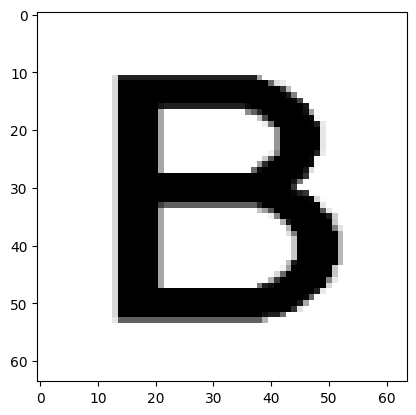

In [504]:
print(labels[0])
print(images[0].shape)
show(images[0])

## Data Augmentation

In [505]:
labels = tf.keras.utils.to_categorical([label_to_index(label) for label in labels], num_classes=36)

def custom_preprocessing(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated_image = cv2.erode(image, kernel, iterations=1)
    img_array = dilated_image.reshape(dilated_image.shape + (1,))
    return img_array

datagen = ImageDataGenerator(
    rotation_range=6,
    width_shift_range=0.07, # up-down
    height_shift_range=0.01, # left-right
    shear_range=0.08,
    zoom_range=0.27,
    horizontal_flip=False,
    fill_mode='nearest',
    preprocessing_function=custom_preprocessing
)

augmented_images = []
augmented_labels = []

for i, image in enumerate(images):
    img_array = image.reshape((1,) + image.shape)
    label = labels[i]

    j = 0
    for batch in datagen.flow(img_array, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        j += 1
        if j >= num_augmented_images:
            break

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

augmented_images = augmented_images / 255.0

# 80% train, 10% validate, 10% test
x_train, x_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=1)

In [506]:
x_train.shape, x_val.shape, x_test.shape

((22400, 64, 64, 1), (2800, 64, 64, 1), (2800, 64, 64, 1))

In [507]:
labels[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [508]:
import random

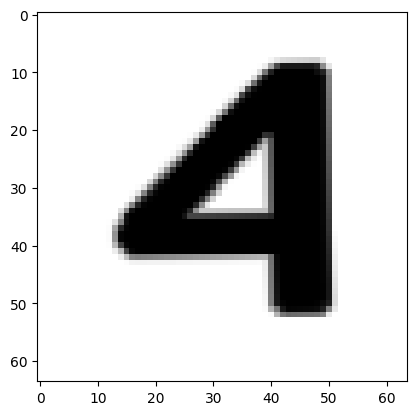

In [509]:
show(x_train[random.randint(0, 150)])

## Model

In [510]:
model = Sequential([
    # modified lenet
    Conv2D(16, (5, 5), activation='relu', input_shape=(img_height, img_width, 1)),
    AveragePooling2D(pool_size=(2, 2), strides=2),

    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(36, activation='sigmoid')
])

In [511]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.0003,
    restore_best_weights=True
)

model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
700/700 [==============================] - 114s 162ms/step - loss: 0.0366 - accuracy: 0.7896 - val_loss: 7.3246e-04 - val_accuracy: 0.9986
Epoch 2/10
700/700 [==============================] - 108s 155ms/step - loss: 0.0015 - accuracy: 0.9959 - val_loss: 4.6244e-05 - val_accuracy: 1.0000
Epoch 3/10
700/700 [==============================] - 114s 163ms/step - loss: 0.0010 - accuracy: 0.9978 - val_loss: 9.5141e-06 - val_accuracy: 1.0000
Epoch 4/10
700/700 [==============================] - 110s 157ms/step - loss: 6.5408e-04 - accuracy: 0.9983 - val_loss: 5.4350e-05 - val_accuracy: 0.9996
Epoch 5/10
700/700 [==============================] - 109s 156ms/step - loss: 3.9988e-04 - accuracy: 0.9988 - val_loss: 4.7004e-06 - val_accuracy: 1.0000


In [512]:
# notify that training is finished (optional)
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [513]:
model.save('ocr.keras')

## (Debug) visualise what CNN sees

In [514]:
def visualize2(model, layer, img, r, c):
  from keras import Model
  # expand dimensions so that it represents a single 'sample'
  img = np.expand_dims(img, axis=0)
  outputs = [layer.output]
  model = Model(inputs=model.inputs, outputs=outputs)
  # get feature map for first hidden layer
  feature_maps = model.predict(img)
  for fmap in feature_maps:
  # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(r):
      for _ in range(c):
        # specify subplot and turn of axis
        ax = plt.subplot(r, c, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(fmap[:, :, ix-1], cmap='gray')
        ix += 1

In [515]:
# plt.figure()
# img = x_test[41] # A
# show(img)
# plt.figure()
# visualize2(model, model.layers[0], img, 2, 2)
# plt.figure()
# visualize2(model, model.layers[1], img, 2, 2)
# plt.figure()
# visualize2(model, model.layers[2], img, 4, 4)
# plt.figure()
# visualize2(model, model.layers[3], img, 4, 4)
# # plt.figure()
# # visualize2(model, model.layers[4], img, 4, 8)

## Validate the model

A


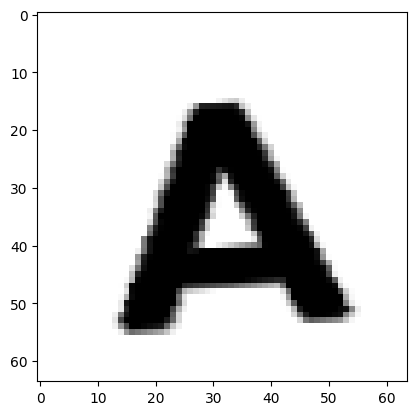

In [516]:
# Test on random character
img_to_pred = x_test[random.randint(0, 150)]
img = np.expand_dims(img_to_pred, axis=0)
predictions = model.predict(img, verbose=0)
predicted_class_index = np.argmax(predictions)
predicted_label = index_to_label(predicted_class_index)
print(predicted_label)
show(img_to_pred)

In [517]:
import itertools

In [518]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [519]:
from sklearn.metrics import confusion_matrix

In [520]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

88/88 [==============================] - 5s 54ms/step - loss: 4.4387e-05 - accuracy: 1.0000
Test score: 4.438749238033779e-05
Test accuracy: 1.0


In [521]:
predict = model.predict(x_test)
predicted_classes = np.argmax(predict,axis=1)

88/88 [==============================] - 4s 41ms/step


Confusion matrix, without normalization
[[77  0  0 ...  0  0  0]
 [ 0 83  0 ...  0  0  0]
 [ 0  0 71 ...  0  0  0]
 ...
 [ 0  0  0 ... 70  0  0]
 [ 0  0  0 ...  0 84  0]
 [ 0  0  0 ...  0  0 69]]


<Figure size 640x480 with 0 Axes>

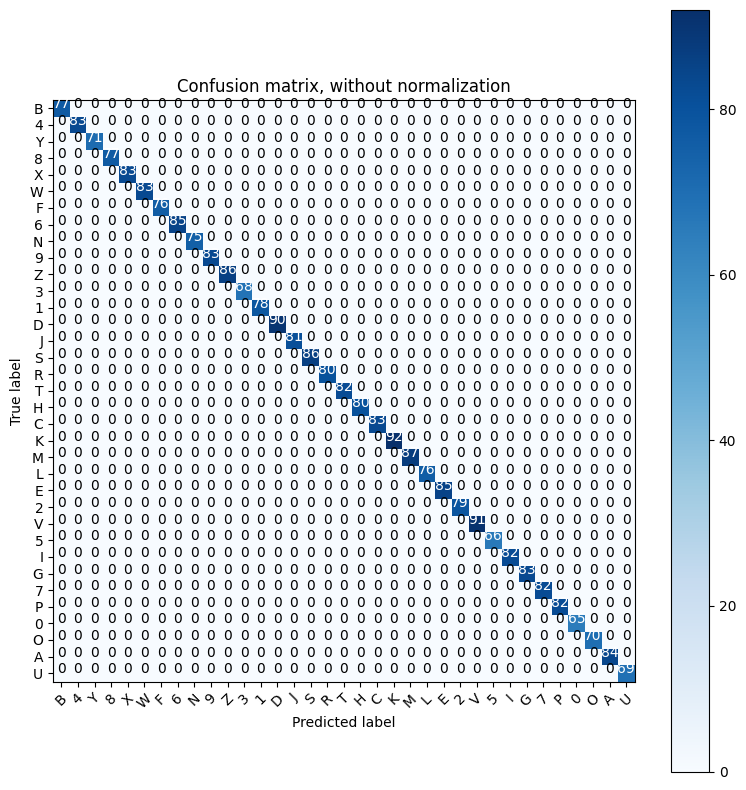

In [522]:
yt = np.argmax(y_test, axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == yt)[0]
incorrect_indices = np.nonzero(predicted_classes != yt)[0]
cnf_matrix = confusion_matrix(yt, predicted_classes)

class_names = labels_text

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

## (Optional) Validate on real data

In [523]:
expected = "W0104E"
got = ""
for i in range(6):
        img = np.load(f'letters_cut/{i}.npy')
        resized_image = cv2.resize(img, (img_width, img_height))
        img = np.expand_dims(resized_image, axis=0)
        predictions = model.predict(img, verbose=0)
        predicted_class_index = np.argmax(predictions)
        predicted_label = index_to_label(predicted_class_index)
        got += predicted_label
print(expected)
print(got)

W0104E
W0104E


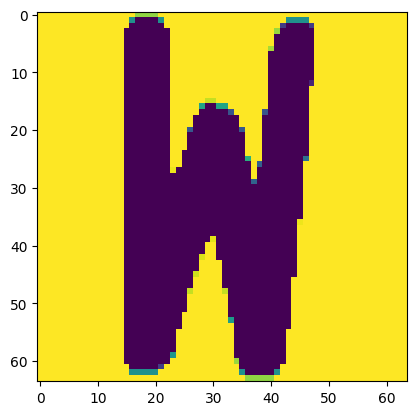

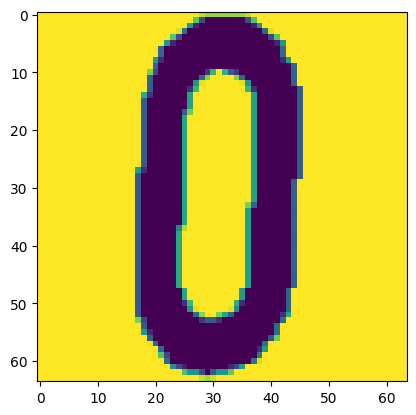

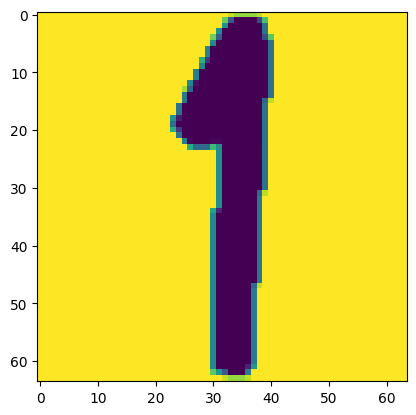

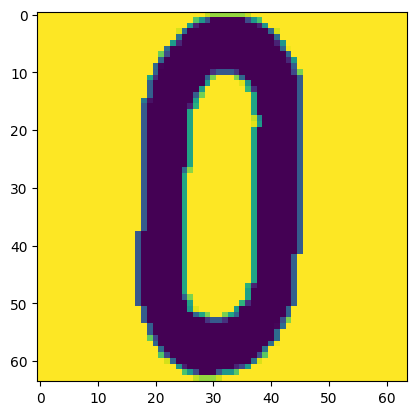

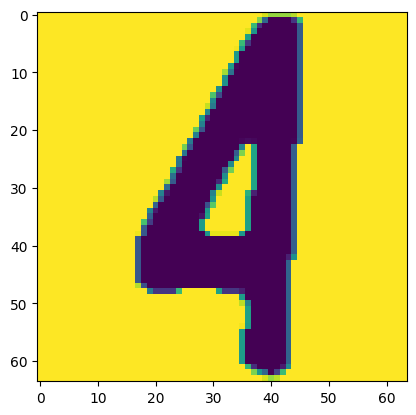

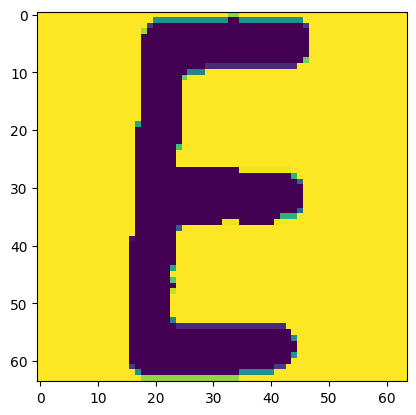

In [524]:
for i in range(6):
        img = np.load(f'letters_cut/{i}.npy')
        plt.figure()
        resized_image = cv2.resize(img, (img_width, img_height))
        plt.imshow(resized_image)